In [1]:
import xarray as xr
import pandas as pd
import numpy as np
import geopandas as gpd
import matplotlib.pyplot as plt
import cartopy.crs as ccrs
from sklearn.cluster import KMeans

# NARR
### Filter to Surface Level

In [7]:
ds = xr.open_dataset('../data/narr-a_221_19790108_0000_000.grb',engine='cfgrib',filter_by_keys={'stepType':'instant','typeOfLevel': 'surface'},backend_kwargs={'errors': 'ignore'})
print(ds)

Ignoring index file '../data/narr-a_221_19790108_0000_000.grb.5b7b6.idx' incompatible with GRIB file


<xarray.Dataset> Size: 4MB
Dimensions:     (y: 277, x: 349)
Coordinates:
    time        datetime64[ns] 8B ...
    step        timedelta64[ns] 8B ...
    surface     float64 8B ...
    latitude    (y, x) float64 773kB ...
    longitude   (y, x) float64 773kB ...
    valid_time  datetime64[ns] 8B ...
Dimensions without coordinates: y, x
Data variables:
    talm2       (y, x) float32 387kB ...
    t2ag2       (y, x) float32 387kB ...
    tprl1       (y, x) float32 387kB ...
    tprg3       (y, x) float32 387kB ...
    tpg200      (y, x) float32 387kB ...
    tpg80       (y, x) float32 387kB ...
Attributes:
    GRIB_edition:            1
    GRIB_centre:             kwbc
    GRIB_centreDescription:  US National Weather Service - NCEP
    GRIB_subCentre:          15
    Conventions:             CF-1.7
    institution:             US National Weather Service - NCEP
    history:                 2024-09-26T10:41 GRIB to CDM+CF via cfgrib-0.9.1...


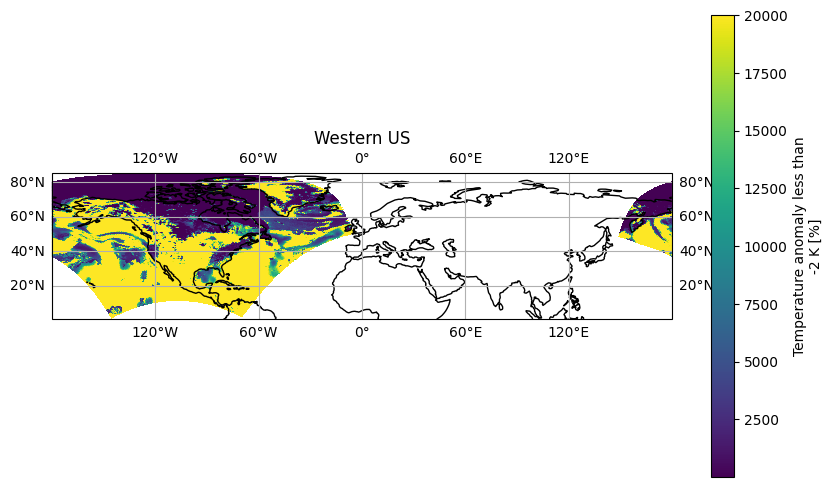

In [9]:
data = ds['talm2']
fig, ax = plt.subplots(figsize=(10, 6), subplot_kw={'projection': ccrs.PlateCarree()})

data.plot(ax=ax, cmap='viridis', transform=ccrs.PlateCarree(), x='longitude', y='latitude')

ax.coastlines()
ax.gridlines(draw_labels=True)

plt.title("Western US")
plt.show()

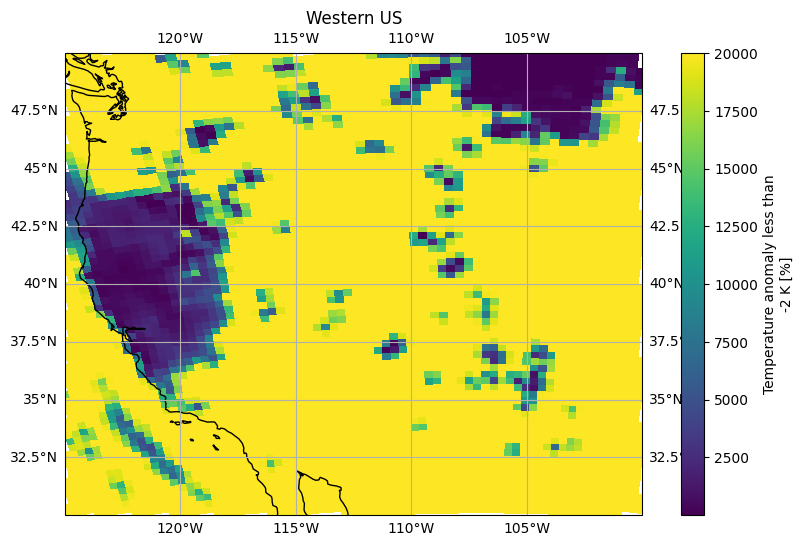

In [40]:
lat_min, lat_max = 30, 50  # Latitude range for Western U.S.
lon_min, lon_max = 235, 260 # Longitude range for Western U.S.

ds_west_us = ds.where(
    (ds['latitude'] >= lat_min) & (ds['latitude'] <= lat_max) &
    (ds['longitude'] >= lon_min) & (ds['longitude'] <= lon_max),
    drop=True
)

data = ds_west_us['talm2']
fig, ax = plt.subplots(figsize=(10, 6), subplot_kw={'projection': ccrs.PlateCarree()})

# Plot the data with the Lambert Conformal projection
data.plot(ax=ax, cmap='viridis', transform=ccrs.PlateCarree(), x='longitude', y='latitude')

ax.set_extent([lon_min, lon_max, lat_min, lat_max], crs=ccrs.PlateCarree())
ax.coastlines()
ax.gridlines(draw_labels=True)

plt.title("Western US")
plt.show()

### Filter by Isobaric Pressure 

In [10]:
ds = xr.open_dataset('../data/narr-a_221_19790108_0000_000.grb',engine='cfgrib',filter_by_keys={'typeOfLevel': 'isobaricInhPa'})
print(ds)

Ignoring index file '../data/narr-a_221_19790108_0000_000.grb.5b7b6.idx' incompatible with GRIB file


<xarray.Dataset> Size: 24MB
Dimensions:        (isobaricInhPa: 29, y: 277, x: 349)
Coordinates:
    time           datetime64[ns] 8B ...
    step           timedelta64[ns] 8B ...
  * isobaricInhPa  (isobaricInhPa) float64 232B 1e+03 975.0 ... 125.0 100.0
    latitude       (y, x) float64 773kB ...
    longitude      (y, x) float64 773kB ...
    valid_time     datetime64[ns] 8B ...
Dimensions without coordinates: y, x
Data variables:
    tpag10         (isobaricInhPa, y, x) float32 11MB ...
    unknown        (isobaricInhPa, y, x) float32 11MB ...
Attributes:
    GRIB_edition:            1
    GRIB_centre:             kwbc
    GRIB_centreDescription:  US National Weather Service - NCEP
    GRIB_subCentre:          15
    Conventions:             CF-1.7
    institution:             US National Weather Service - NCEP
    history:                 2024-09-26T10:42 GRIB to CDM+CF via cfgrib-0.9.1...


In [3]:
lat_min, lat_max = 30, 50
lon_min, lon_max = 235, 260

# GWIS: GlobFire

In [ ]:
#Combining all the years into one .shp; this will take about 5 minutes to run

western_us_bounds = {
    "min_longitude": -125,
    "max_longitude": -100,
    "min_latitude": 32,
    "max_latitude": 49
}

main = gpd.read_file('../data/globfire/original_globfire_filtered_2002.shp').to_crs(epsg=4326).cx[
    western_us_bounds["min_longitude"]:western_us_bounds["max_longitude"],
    western_us_bounds["min_latitude"]:western_us_bounds["max_latitude"]]

for year in np.arange(2003,2024):
    print(year)
    temp = gpd.read_file(f"../data/globfire/original_globfire_filtered_{year}.shp")
    temp = temp.to_crs(epsg=4326).cx[
        western_us_bounds["min_longitude"]:western_us_bounds["max_longitude"],
        western_us_bounds["min_latitude"]:western_us_bounds["max_latitude"]]
    main = pd.concat([main,temp])

main.to_file("../data/full_globfire.shp")

(32.0, 49.0)

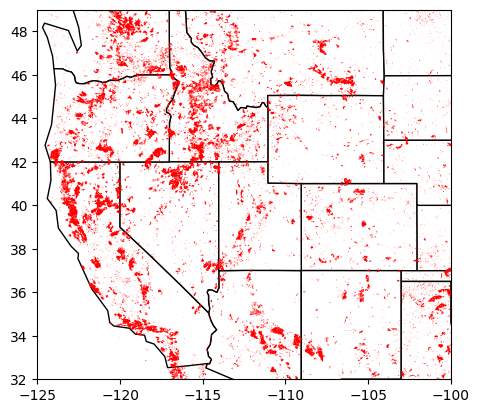

In [13]:
states = gpd.read_file('../data/state_borders/ne_110m_admin_1_states_provinces.shp')

ax = states.plot(color='white', edgecolor='black')

main.plot(ax=ax,color="red",markersize = main["area_ha"]/np.max(main["area_ha"]))
ax.set_xlim([-125,-100])
ax.set_ylim([32,49])

## Ok back to NARR

/Users/eliotcarlson/Desktop/columbia/capstone/.venv/lib/python3.10/site-packages/xarray/conventions.py:284: SerializationWarning: variable 'air' has multiple fill values {np.float32(9.96921e+36), np.float32(-9.96921e+36)} defined, decoding all values to NaN.
  var = coder.decode(var, name=name)


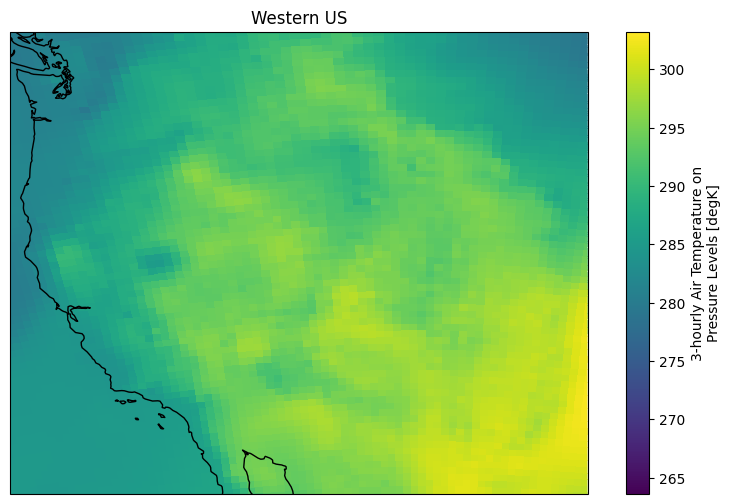

In [20]:
rootgrp = xr.open_dataset("/Users/eliotcarlson/Downloads/air.200009.nc")
data = rootgrp['air'].isel(time=3,level=4)

# Create the figure and axis using the Lambert Conformal projection
fig, ax = plt.subplots(figsize=(10, 6), subplot_kw={'projection': ccrs.PlateCarree()})

# # Plot the data using Lambert Conformal projection
data.plot(ax=ax, cmap='viridis',transform=ccrs.PlateCarree(),x='lon',y='lat')

ax.set_extent([lon_min, lon_max, lat_min, lat_max], crs=ccrs.PlateCarree())

# # Add coastlines and gridlines
ax.coastlines(resolution='50m')


# Set the title and show the plot
plt.title("Western US")
plt.show()

/Users/eliotcarlson/Desktop/columbia/capstone/.venv/lib/python3.10/site-packages/xarray/conventions.py:284: SerializationWarning: variable 'air' has multiple fill values {np.float32(9.96921e+36), np.float32(-9.96921e+36)} defined, decoding all values to NaN.
  var = coder.decode(var, name=name)


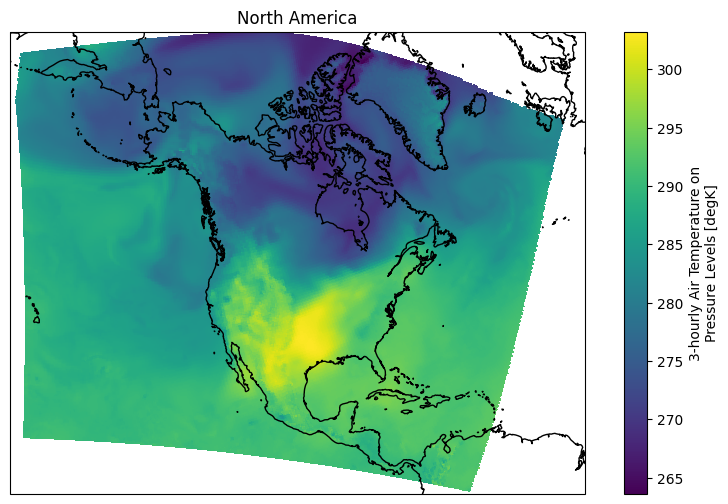

In [33]:
rootgrp = xr.open_dataset("/Users/eliotcarlson/Downloads/air.200009.nc")
data = rootgrp['air'].isel(time=3,level=4)

# Create the figure and axis using the Lambert Conformal projection
fig, ax = plt.subplots(figsize=(10, 6), subplot_kw={'projection': ccrs.LambertConformal()})

# # Plot the data using Lambert Conformal projection
data.plot(ax=ax, cmap='viridis',transform=ccrs.PlateCarree(),x='lon',y='lat')

#ax.set_extent([lon_min, lon_max, lat_min, lat_max], crs=ccrs.PlateCarree())

# # Add coastlines and gridlines
ax.coastlines(resolution='50m')

# Set the title and show the plot
plt.title("North America")
plt.show()

/Users/eliotcarlson/Desktop/columbia/capstone/.venv/lib/python3.10/site-packages/xarray/conventions.py:284: SerializationWarning: variable 'air' has multiple fill values {np.float32(9.96921e+36), np.float32(-9.96921e+36)} defined, decoding all values to NaN.
  var = coder.decode(var, name=name)


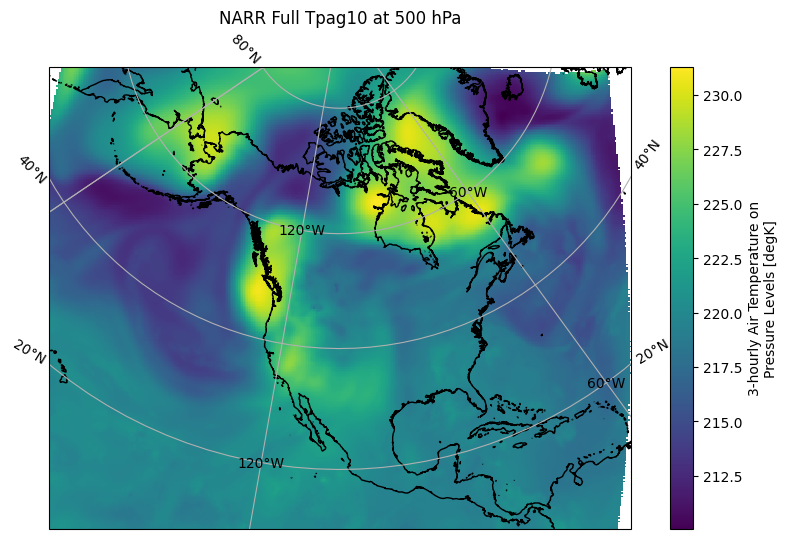

In [18]:
lambert_crs = ccrs.LambertConformal(
    central_longitude=-107.0,
    central_latitude=50.0,
    standard_parallels=[50.0, 50.0],
    false_easting=5632642.22547,
    false_northing=4612545.65137
)

rootgrp = xr.open_dataset("/Users/eliotcarlson/Downloads/air.200009.nc")
data = rootgrp['air'].isel(time=6,level=24)

fig, ax = plt.subplots(figsize=(10, 6), subplot_kw={'projection': lambert_crs})
data.plot(ax=ax, cmap='viridis',transform=None)

# Set the geographic extent of the Western U.S. (use PlateCarree for this)
# ax.set_extent([lon_min, lon_max, lat_min, lat_max], crs=ccrs.PlateCarree())

# Add coastlines and gridlines
ax.coastlines(resolution='10m')
ax.gridlines(draw_labels=True)

plt.show()

In [30]:
%matplotlib notebook
from matplotlib.animation import FuncAnimation

rootgrp = xr.open_dataset("/Users/eliotcarlson/Downloads/air.200009.nc")
data = rootgrp['air'].isel(level=24)

fig, ax = plt.subplots(figsize=(10, 6), subplot_kw={'projection': lambert_crs})

gl = ax.gridlines(draw_labels=False)
ax.coastlines(resolution='10m')

# Initialize with the first time step
initial_data = data.isel(time=0).values
# Create an image with imshow using the initial data
img = ax.imshow(initial_data, origin='upper', cmap='viridis', extent=(data['x'].min(), data['x'].max(),
                                                                     data['y'].min(), data['y'].max()),
                transform=lambert_crs)

# Update function for animation
def update(frame):
    img.set_array(data.isel(time=frame).values)

ani = FuncAnimation(fig, update, frames=len(data['time']), repeat=True)

plt.show()

ani.save("air200009.gif", writer='ffmpeg')

/Users/eliotcarlson/Desktop/columbia/capstone/.venv/lib/python3.10/site-packages/xarray/conventions.py:284: SerializationWarning: variable 'air' has multiple fill values {np.float32(9.96921e+36), np.float32(-9.96921e+36)} defined, decoding all values to NaN.
  var = coder.decode(var, name=name)


<IPython.core.display.Javascript object>

MovieWriter ffmpeg unavailable; using Pillow instead.


In [12]:
data = xr.open_dataset('NCSS.nc')

/Users/eliotcarlson/Desktop/columbia/capstone/.venv/lib/python3.10/site-packages/xarray/conventions.py:284: SerializationWarning: variable 'air' has multiple fill values {np.float32(9.96921e+36), np.float32(-9.96921e+36)} defined, decoding all values to NaN.
  var = coder.decode(var, name=name)


/Users/eliotcarlson/Desktop/columbia/capstone/.venv/lib/python3.10/site-packages/xarray/conventions.py:284: SerializationWarning: variable 'air' has multiple fill values {np.float32(9.96921e+36), np.float32(-9.96921e+36)} defined, decoding all values to NaN.
  var = coder.decode(var, name=name)


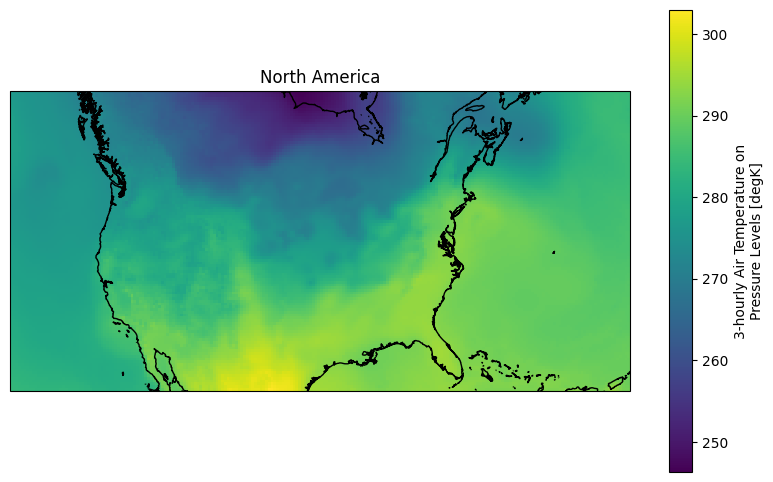

In [18]:
lambert_crs = ccrs.LambertConformal(
    central_longitude=-107.0,
    central_latitude=50.0,
    standard_parallels=[50.0, 50.0],
    false_easting=5632642.22547,
    false_northing=4612545.65137
)

data = xr.open_dataset('NCSS.nc')
data = data['air'].isel(level=2)

# Create the figure and axis using the Lambert Conformal projection
fig, ax = plt.subplots(figsize=(10, 6), subplot_kw={'projection': lambert_crs})

# # Plot the data using Lambert Conformal projection
data.plot(ax=ax, cmap='viridis',transform=None)

ax.coastlines(resolution='10m')

plt.title("North America")
plt.show()

In [10]:
print(data)

<xarray.DataArray 'air' (time: 1, y: 109, x: 226)> Size: 99kB
[24634 values with dtype=float32]
Coordinates:
    level    float32 4B 900.0
  * x        (x) float32 904B 3.149e+06 3.181e+06 ... 1.042e+07 1.045e+07
  * y        (y) float32 436B 2.143e+06 2.175e+06 ... 5.616e+06 5.649e+06
  * time     (time) datetime64[ns] 8B 1979-03-31T21:00:00
Attributes: (12/13)
    GRIB_id:        11
    GRIB_name:      TMP
    dataset:        NARR 3-hourly
    grid_mapping:   Lambert_Conformal
    level_desc:     Pressure Levels
    long_name:      3-hourly Air Temperature on Pressure Levels
    ...             ...
    standard_name:  air_temperature
    statistic:      Individual Obs
    units:          degK
    valid_range:    [137.5 362.5]
    var_desc:       Air temperature
    actual_range:   [190.02036 311.4657 ]


/Users/eliotcarlson/Desktop/columbia/capstone/.venv/lib/python3.10/site-packages/xarray/conventions.py:284: SerializationWarning: variable 'air' has multiple fill values {np.float32(9.96921e+36), np.float32(-9.96921e+36)} defined, decoding all values to NaN.
  var = coder.decode(var, name=name)


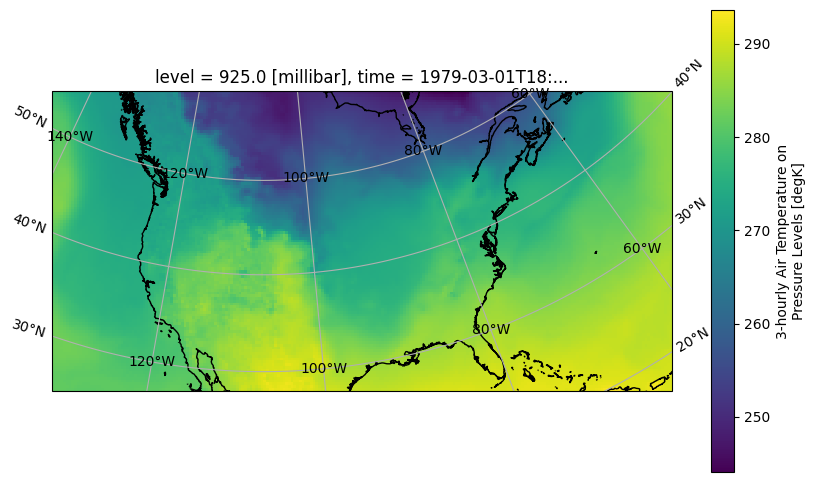

In [22]:
data = xr.open_dataset('NCSS2.nc')

data = data['air'].isel(time=6,level=3)

fig, ax = plt.subplots(figsize=(10, 6), subplot_kw={'projection': lambert_crs})
data.plot(ax=ax, cmap='viridis',transform=None)

# Set the geographic extent of the Western U.S. (use PlateCarree for this)
# ax.set_extent([lon_min, lon_max, lat_min, lat_max], crs=ccrs.PlateCarree())

# Add coastlines and gridlines
ax.coastlines(resolution='10m')
ax.gridlines(draw_labels=True)

plt.show()

In [27]:
data = xr.open_dataset('NCSS2.nc')

/Users/eliotcarlson/Desktop/columbia/capstone/.venv/lib/python3.10/site-packages/xarray/conventions.py:284: SerializationWarning: variable 'air' has multiple fill values {np.float32(9.96921e+36), np.float32(-9.96921e+36)} defined, decoding all values to NaN.
  var = coder.decode(var, name=name)


In [28]:
stacked_data = data['air'].isel(time=1).stack(points=("y", "x")).transpose("points","level")

In [30]:
kmeans = KMeans(n_clusters=3).fit(stacked_data)

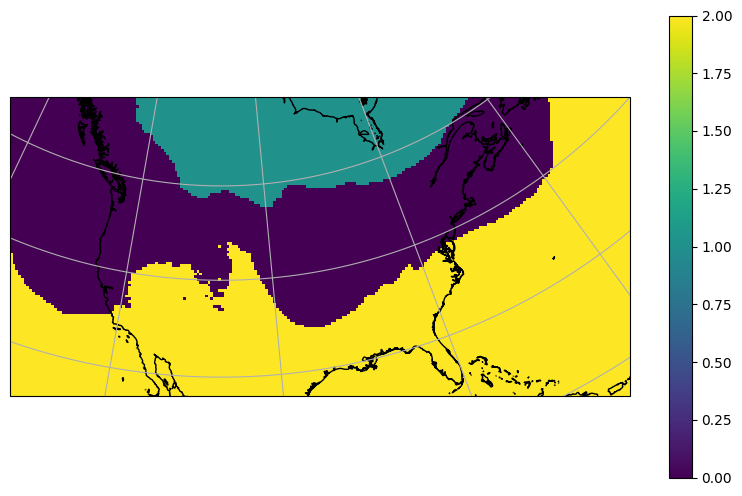

In [31]:
cluster_labels = xr.DataArray(kmeans.labels_, coords={"points": stacked_data["points"]})
cluster_labels = cluster_labels.unstack("points")


fig, ax = plt.subplots(figsize=(10, 6), subplot_kw={'projection': lambert_crs})
cluster_labels.plot(ax=ax, cmap='viridis',transform=None)

# Add coastlines and gridlines
ax.coastlines(resolution='10m')
ax.gridlines(draw_labels=False)

plt.show()